<a href="https://colab.research.google.com/github/Muhammad-Raafat/Muhammad-Raafat/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install  mediapipe

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Reading the data

In [4]:
# Loading AFLW2000 Data
import zipfile
path = '/content/gdrive/MyDrive/AFLW2000-3D.zip'
zip_object = zipfile.ZipFile(file = path,mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [5]:
images = sorted(glob.glob("/content/AFLW2000/*.jpg"))
len(images)

2000

In [6]:
mat_files = sorted(glob.glob("/content/AFLW2000/*.mat"))
len(mat_files)

2000

# Extracting and modifying features and labels

In [7]:
#function to extract single label
def getting_poses(file):
    labels = []
    mat_file = sio.loadmat(file)
    pose_param = mat_file["Pose_Para"][0][:3]
    return pose_param  

In [8]:
# function to extract features and labels
def getting_data(images,files):
    labels = []
    x_1 = []
    y_1 = []
    face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)
    for (image,file) in zip(images,files):
        img = cv2.imread(image)
        height,width,_ = img.shape
        img_new = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        result = face_mesh.process(img_new)
        if result.multi_face_landmarks != None:
            for face in result.multi_face_landmarks:
                x_list = []
                y_list = []
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    relative_x = int(x * width)
                    relative_y = int(y * height)
                    x_list.append(relative_x)
                    y_list.append(relative_y)
                x_array = np.array(x_list)
                y_array = np.array(y_list)

                x_1.append(x_array)
                y_1.append(y_array)

                x_arr = np.array(x_1)
                y_arr = np.array(y_1)
                pose_param = getting_poses(file)
                labels.append(pose_param)
    labels = np.array(labels)
    return x_arr,y_arr,labels

In [9]:
x_array,y_array,labels = getting_data(images,mat_files)
print(x_array.shape)
print(y_array.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


## Normalizing the data

In [10]:
# the data should be normalized around the center of the face
# center 195
# Top of Head = 10
# Bottom of Head = 152
x_center = x_array - x_array[:,195].reshape(-1,1)
y_center = y_array - y_array[:,195].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 152
x_152 = x_array[:,152]
x_10 = x_array[:,10]
y_152 = y_array[:,152]
y_10 = y_array[:,10]

# computing the distance
distance = np.linalg.norm(np.array((x_10,y_10)) - np.array((x_152,y_152)),axis = 0).reshape(-1,1)
x_norm = x_center / distance
y_norm = y_center / distance



# concatinating the X and Y points to form the compelete features
features = np.hstack([x_norm,y_norm])

print(features.shape)

(1853, 936)


## Apply The Model

In [11]:
x = features.copy()
y = labels.copy()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [13]:
#test the data 
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)

## Using GridSearch to find the best parameters 

In [14]:
param_grid = {'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],'estimator__C':[0.01,0.1,1,10,100]}
scoring = 'neg_mean_squared_error'
svr_pose = SVR()
multi_output = MultiOutputRegressor(svr_pose)
grid_search = GridSearchCV(estimator=multi_output, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=SVR()),
             param_grid={'estimator__C': [0.01, 0.1, 1, 10, 100],
                         'estimator__kernel': ['linear', 'poly', 'rbf',
                                               'sigmoid']},
             scoring='neg_mean_squared_error')

In [15]:
# test the model 
y_pred = grid_search.predict(x_val)
print(f"R2 score:validation = {r2_score(y_val,y_pred)}")
mse = mean_squared_error(y_val, y_pred)

print("Mean squared error on validation data:", mse)

R2 score:validation = 0.8092922237934849
Mean squared error on validation data: 0.023982547066660902


In [16]:
#function to get the main points 
def getting_main_points(image):
    features = []
    face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)
    img = image
    height,width,_ = img.shape
    img_new = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    result = face_mesh.process(img_new)
    nose_coordinates = []
    if result.multi_face_landmarks != None:
        for face in result.multi_face_landmarks:
            i =0
            x_array = []
            y_array = []
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                relative_x = int(x * width)
                relative_y = int(y * height)
                x_array.append(relative_x)
                y_array.append(relative_y)
                if i == 5:
                  nose_coordinates.append(int(x * width))
                  nose_coordinates.append(int(y * height))
                i += 1

        # converting the x anx y to numpy arrays
        x_array = np.array(x_array)
        y_array = np.array(y_array)

        # centering the points arround the 195th point 
        x_center = x_array - x_array[195]
        y_center = y_array - y_array[195]

        # computing the distance
        distance = np.linalg.norm(np.array((x_array[10],y_array[10])) - np.array((x_array[152],y_array[152])),axis = 0)
        x_norm = x_center / distance
        y_norm = y_center / distance

        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        features = np.hstack([x_norm,y_norm]).reshape(1,-1)


    return features,nose_coordinates

In [17]:
# a function to draw the axes
def draw_axes(img, pitch, yaw, roll, tx = None, ty = None, size=100):

    yaw = -yaw
    if tx != None and ty != None:
      tdx = tx
      tdy = ty
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1.25, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty

    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)

    return new_img

## Testing image

In [18]:
test_image = cv2.imread(images[201])
x_1,nose_coordinate = getting_main_points(test_image)
y_pred = grid_search.predict(x_1)

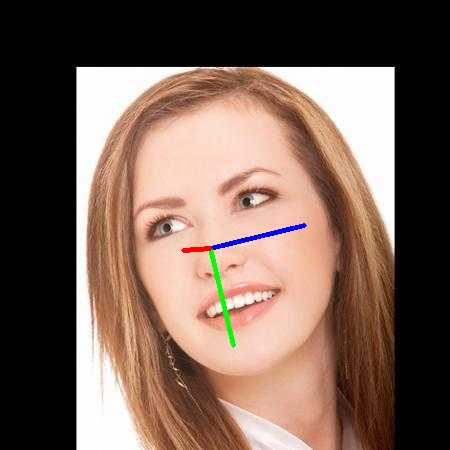

In [19]:
cv2_imshow(draw_axes(test_image, y_pred[0,0],y_pred[0,1], y_pred[0,2],tx = nose_coordinate[0],ty = nose_coordinate[1]))

## Testing video

In [20]:
cap = cv2.VideoCapture("/content/WhatsApp Video 2023-02-13 flip.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)

# Get the frame size (width, height) of the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_name = 'output.mp4'
video = cv2.VideoWriter(video_name, fourcc, fps, (frame_width, frame_height))

while (cap.isOpened()):

  ret, frame = cap.read()

  if not ret:
    break 

  x_frame,nose_coo = getting_main_points(frame)
  x_frame = pd.DataFrame(x_frame)
  if len(nose_coo) == 2:
    nose_coordinate = nose_coo

  if x_frame.shape[1] == 936:
      y_pred = grid_search.predict(x_frame)
  
  result_img = draw_axes(frame, y_pred[0,0],y_pred[0,1], y_pred[0,2],tx = nose_coordinate[0],ty = nose_coordinate[1])
  video.write(result_img)

cv2.destroyAllWindows()
video.release()